In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from prophet import Prophet
import itertools
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# path = '/content/drive/MyDrive/01_ITE/Projects/Data_Science/datasets/'

path = 'datasets/'
cumtd_data = '00CUMTD_Route_Ridership_By_Day_September_2022_2023.csv'
data_file = path + cumtd_data # get the directory of the file

In [3]:
# df1: Dataframe for monthly data
df1 = pd.read_csv(data_file) # read in the csv file
df1

,Date,Line,In (Sum),Out (Sum),Load (Avg.),Load max,#APC-Trips
0,2022-08-31T19:00:00-05:00,1 YELLOW ALT,34,34,8.1,33,2
1,2022-08-31T19:00:00-05:00,10W GOLD ALT,47,47,14.6,43,1
2,2022-08-31T19:00:00-05:00,1N YELLOW ALT,140,140,24.0,87,2
3,2022-08-31T19:00:00-05:00,1N YELLOW ALT PM,41,41,15.5,41,1
4,2022-08-31T19:00:00-05:00,1S YELLOW ALT,120,120,8.2,56,3
...,...,...,...,...,...,...,...
15774,2023-09-29T19:00:00-05:00,TEAL LATE NIGHT SATURDAY,163,163,3.2,21,16
15775,2023-09-29T19:00:00-05:00,TEAL SATURDAY,"1,980","1,980",9.0,53,74
15776,2023-09-29T19:00:00-05:00,YELLOW EVENING SATURDAY,868,868,6.0,79,26
15777,2023-09-29T19:00:00-05:00,YELLOW LATE NIGHT SATURDAY,79,79,0.7,13,21


In [4]:
columns_to_traverse = df1.keys()[2:] # these are the columns we will be traversing for out data analysis
columns_to_traverse

Index(['In (Sum)', 'Out (Sum)', 'Load (Avg.)', 'Load max', '#APC-Trips'], dtype='object')

In [5]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1

,Date,Line,In (Sum),Out (Sum),Load (Avg.),Load max,#APC-Trips
0,2022-08-31 19:00:00-05:00,1 YELLOW ALT,34,34,8.1,33,2
1,2022-08-31 19:00:00-05:00,10W GOLD ALT,47,47,14.6,43,1
2,2022-08-31 19:00:00-05:00,1N YELLOW ALT,140,140,24.0,87,2
3,2022-08-31 19:00:00-05:00,1N YELLOW ALT PM,41,41,15.5,41,1
4,2022-08-31 19:00:00-05:00,1S YELLOW ALT,120,120,8.2,56,3
...,...,...,...,...,...,...,...
15774,2023-09-29 19:00:00-05:00,TEAL LATE NIGHT SATURDAY,163,163,3.2,21,16
15775,2023-09-29 19:00:00-05:00,TEAL SATURDAY,"1,980","1,980",9.0,53,74
15776,2023-09-29 19:00:00-05:00,YELLOW EVENING SATURDAY,868,868,6.0,79,26
15777,2023-09-29 19:00:00-05:00,YELLOW LATE NIGHT SATURDAY,79,79,0.7,13,21


In [6]:
bus_lines = df1['Line'].unique() # we want to see how many unique bus lines there are
print(f'CUMTD bus lines: {bus_lines}')

CUMTD bus lines: ['1 YELLOW ALT' '10W GOLD ALT' '1N YELLOW ALT' '1N YELLOW ALT PM'
 '1S YELLOW ALT' '3S LAVENDER ALT' '5E GREEN EXPRESS 1 ALT'
 '5E GREEN EXPRESS ALT' '5W GREEN ALT 2' '5W GREEN EXPRESS 2'
 '7E GREY ALT' '7W GREY ALT' 'BLUE' 'BRONZE' 'BRONZE ALT' 'BROWN'
 'BROWN ALT' 'BROWN ALT PM' 'BROWN ALT1' 'GOLD' 'GOLD ALT' 'GOLDHOPPER'
 'GREEN' 'GREEN ALT' 'GREEN EVENING' 'GREEN EXPRESS' 'GREEN EXPRESS ALT'
 'GREEN LATE NIGHT' 'GREENHOPPER' 'GREENHOPPER EVENING' 'GREY' 'GREY ALT'
 'GREY EVENING' 'ILLINI' 'ILLINI EVENING' 'LAVENDER' 'LAVENDER ALT'
 'LIME EVENING' 'LINK' 'NAVY' 'ORANGE' 'ORANGE ALT' 'ORANGEHOPPER' 'PINK'
 'PINK ALT' 'RAVEN' 'RED' 'RUBY' 'RUBY EVENING' 'SILVER' 'SILVER EVENING'
 'SILVER LATE NIGHT' 'TEAL' 'TEAL EVENING' 'TEAL LATE NIGHT' 'YELLOW'
 'YELLOW EVENING' 'YELLOW LATE NIGHT' 'YELLOWHOPPER'
 'GREEN EVENING SATURDAY' 'GREEN LATE NIGHT SATURDAY' 'GREEN SATURDAY'
 'GREENHOPPER EVENING SATURDAY' 'GREY EVENING SATURDAY' 'GREY SATURDAY'
 'ILLINI EVENING SATURDAY' '

In [7]:
silverLine = [line for line in bus_lines if "silver" in line.lower()]
silverLine

['SILVER',
 'SILVER EVENING',
 'SILVER LATE NIGHT',
 'SILVER EVENING SATURDAY',
 'SILVER SATURDAY',
 'SILVER EVENING SUNDAY',
 'SILVER SUNDAY',
 'SILVER LIMITED EVENING SATURDAY',
 'SILVER LIMITED SATURDAY',
 'SILVER LIMITED SUNDAY',
 'SILVER LIMITED EVENING']

In [8]:
# Define the list of line names you're interested in
lines_of_interest = silverLine

# Filter the dataframe based on the list
filtered_dataframe = df1[df1['Line'].isin(lines_of_interest)]
filtered_dataframe

,Date,Line,In (Sum),Out (Sum),Load (Avg.),Load max,#APC-Trips
49,2022-08-31 19:00:00-05:00,SILVER,"3,035","3,035",12.6,75,93
50,2022-08-31 19:00:00-05:00,SILVER EVENING,197,197,4.2,18,15
51,2022-08-31 19:00:00-05:00,SILVER LATE NIGHT,30,30,1.0,9,9
108,2022-09-01 19:00:00-05:00,SILVER,"2,533","2,533",10.1,87,92
109,2022-09-01 19:00:00-05:00,SILVER EVENING,235,235,4.6,22,17
...,...,...,...,...,...,...,...
15747,2023-09-28 19:00:00-05:00,SILVER,"2,818","2,818",11.6,69,92
15748,2023-09-28 19:00:00-05:00,SILVER EVENING,448,448,10.1,45,15
15749,2023-09-28 19:00:00-05:00,SILVER LATE NIGHT,138,138,3.6,33,16
15771,2023-09-29 19:00:00-05:00,SILVER EVENING SATURDAY,688,688,4.7,38,58


In [9]:
for key in columns_to_traverse:
    filtered_dataframe[key] = filtered_dataframe[key].replace(',', '', regex=True)
    filtered_dataframe[key] = filtered_dataframe[key].astype('float64')

C:\Users\louis\AppData\Local\Temp\ipykernel_20708\2574090907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataframe[key] = filtered_dataframe[key].replace(',', '', regex=True)
C:\Users\louis\AppData\Local\Temp\ipykernel_20708\2574090907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataframe[key] = filtered_dataframe[key].astype('float64')
C:\Users\louis\AppData\Local\Temp\ipykernel_20708\2574090907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [10]:
filtered_dataframe

,Date,Line,In (Sum),Out (Sum),Load (Avg.),Load max,#APC-Trips
49,2022-08-31 19:00:00-05:00,SILVER,3035.0,3035.0,12.6,75.0,93.0
50,2022-08-31 19:00:00-05:00,SILVER EVENING,197.0,197.0,4.2,18.0,15.0
51,2022-08-31 19:00:00-05:00,SILVER LATE NIGHT,30.0,30.0,1.0,9.0,9.0
108,2022-09-01 19:00:00-05:00,SILVER,2533.0,2533.0,10.1,87.0,92.0
109,2022-09-01 19:00:00-05:00,SILVER EVENING,235.0,235.0,4.6,22.0,17.0
...,...,...,...,...,...,...,...
15747,2023-09-28 19:00:00-05:00,SILVER,2818.0,2818.0,11.6,69.0,92.0
15748,2023-09-28 19:00:00-05:00,SILVER EVENING,448.0,448.0,10.1,45.0,15.0
15749,2023-09-28 19:00:00-05:00,SILVER LATE NIGHT,138.0,138.0,3.6,33.0,16.0
15771,2023-09-29 19:00:00-05:00,SILVER EVENING SATURDAY,688.0,688.0,4.7,38.0,58.0


In [11]:
filtered_dataframe = filtered_dataframe.set_index('Date')
filtered_dataframe.index

Index([2022-08-31 19:00:00-05:00, 2022-08-31 19:00:00-05:00,
       2022-08-31 19:00:00-05:00, 2022-09-01 19:00:00-05:00,
       2022-09-01 19:00:00-05:00, 2022-09-01 19:00:00-05:00,
       2022-09-02 19:00:00-05:00, 2022-09-02 19:00:00-05:00,
       2022-09-03 19:00:00-05:00, 2022-09-03 19:00:00-05:00,
       ...
       2023-09-26 19:00:00-05:00, 2023-09-26 19:00:00-05:00,
       2023-09-27 19:00:00-05:00, 2023-09-27 19:00:00-05:00,
       2023-09-27 19:00:00-05:00, 2023-09-28 19:00:00-05:00,
       2023-09-28 19:00:00-05:00, 2023-09-28 19:00:00-05:00,
       2023-09-29 19:00:00-05:00, 2023-09-29 19:00:00-05:00],
      dtype='object', name='Date', length=931)

In [12]:
mask = filtered_dataframe['Line'] == 'SILVER'
silv = filtered_dataframe[mask]
silv

,Line,In (Sum),Out (Sum),Load (Avg.),Load max,#APC-Trips
Date,,,,,,
2022-08-31 19:00:00-05:00,SILVER,3035.0,3035.0,12.6,75.0,93.0
2022-09-01 19:00:00-05:00,SILVER,2533.0,2533.0,10.1,87.0,92.0
2022-09-05 19:00:00-05:00,SILVER,2758.0,2758.0,10.9,95.0,97.0
2022-09-06 19:00:00-05:00,SILVER,3160.0,3160.0,12.9,76.0,94.0
2022-09-07 19:00:00-05:00,SILVER,2740.0,2740.0,10.7,66.0,93.0
...,...,...,...,...,...,...
2023-09-24 19:00:00-05:00,SILVER,3441.0,3441.0,14.3,81.0,92.0
2023-09-25 19:00:00-05:00,SILVER,2970.0,2970.0,11.7,79.0,93.0
2023-09-26 19:00:00-05:00,SILVER,3436.0,3436.0,13.8,73.0,92.0


In [13]:
def plot_data(silver,y_var):
    y = silver[y_var]
    y = y.asfreq('D')
    y = y.fillna(y.mean())
    plt.figure(figsize=(20, 6))
    plt.plot(y, label='Observed Data', color='blue')
    plt.title('Load max for silver Line')
    plt.xlabel('Time')
    plt.ylabel(y_var)

In [14]:
def forecast(silver,y_var,step_var):
    y = silver[y_var]
    y = y.asfreq('D')
    y = y.fillna(y.mean())

    model = ExponentialSmoothing(y, seasonal='mul', seasonal_periods=160).fit()
    y_forecasted = model.forecast(steps=step_var)
    print(y_var)
    plt.figure(figsize=(20, 6))
    plt.plot(y, label='Observed', color='blue')
    plt.plot(y_forecasted, label='Forecast', color='red')
    plt.title(y_var+' Forecast using Holt-Winters Method for silver Line')
    plt.xlabel('Time')
    plt.ylabel(y_var)
    plt.legend()
    print(type(y_forecasted))
    print(y_forecasted)

    forecast_df = pd.DataFrame(y_forecasted, columns=['Forecasted Value'])

    # Resetting the index to turn the dates into a separate column
    forecast_df.reset_index(inplace=True)
    forecast_df.rename(columns={'index': 'Date'}, inplace=True)
    forecast_df.to_csv('figures/Kosuke_Silver/predictions/silver_predict' + y_var + '.csv',index=False)

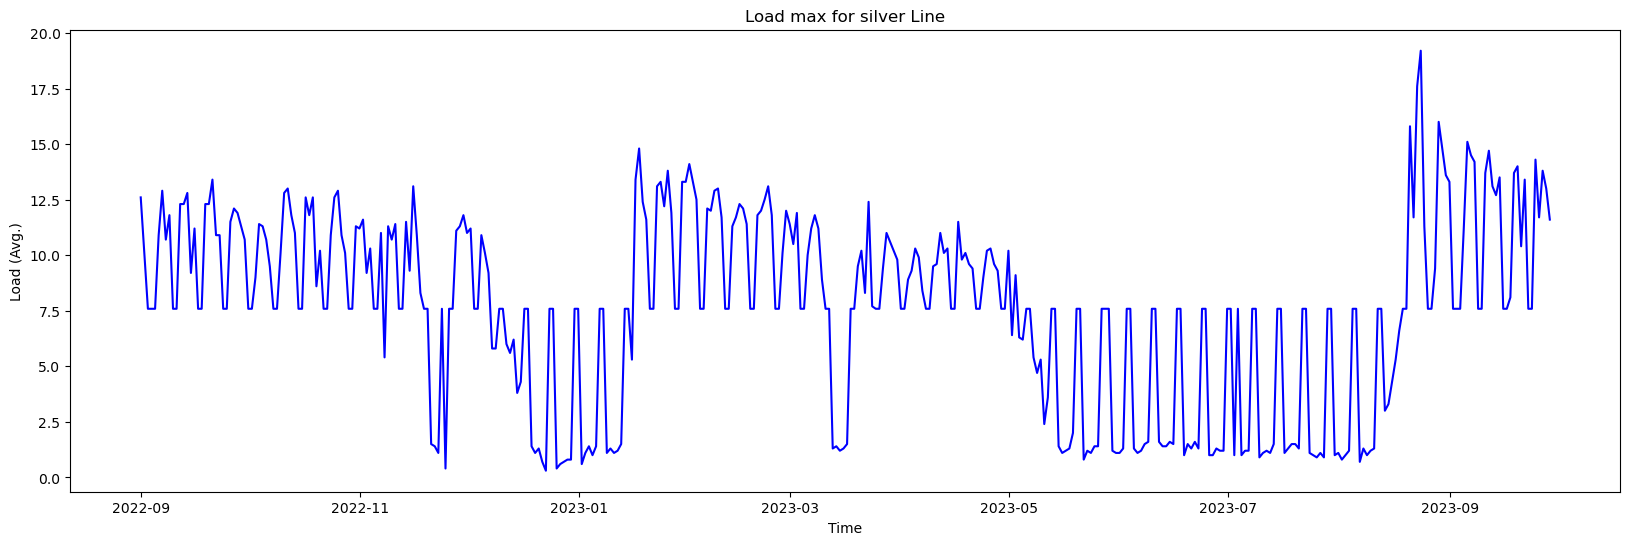

In [15]:
plot_data(silv,columns_to_traverse[2])

C:\Users\louis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\louis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In (Sum)
<class 'pandas.core.series.Series'>
2023-09-29 19:00:00-05:00    2665.848285
2023-09-30 19:00:00-05:00    3061.121691
2023-10-01 19:00:00-05:00    3531.203778
2023-10-02 19:00:00-05:00    3410.692366
2023-10-03 19:00:00-05:00    3152.736686
                                ...     
2024-06-06 19:00:00-05:00    2554.178565
2024-06-07 19:00:00-05:00    1701.643105
2024-06-08 19:00:00-05:00    1688.891699
2024-06-09 19:00:00-05:00    1730.853700
2024-06-10 19:00:00-05:00    1539.503416
Freq: D, Length: 256, dtype: float64
Out (Sum)
<class 'pandas.core.series.Series'>
2023-09-29 19:00:00-05:00    2665.848285
2023-09-30 19:00:00-05:00    3061.121691
2023-10-01 19:00:00-05:00    3531.203778
2023-10-02 19:00:00-05:00    3410.692366
2023-10-03 19:00:00-05:00    3152.736686
                                ...     
2024-06-06 19:00:00-05:00    2554.178565
2024-06-07 19:00:00-05:00    1701.643105
2024-06-08 19:00:00-05:00    1688.891699
2024-06-09 19:00:00-05:00    1730.853700
2024-06-10 

C:\Users\louis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Load (Avg.)
<class 'pandas.core.series.Series'>
2023-09-29 19:00:00-05:00    14.377743
2023-09-30 19:00:00-05:00    13.935126
2023-10-01 19:00:00-05:00    17.949560
2023-10-02 19:00:00-05:00    16.382317
2023-10-03 19:00:00-05:00    14.104171
                               ...    
2024-06-06 19:00:00-05:00    14.921437
2024-06-07 19:00:00-05:00    13.596076
2024-06-08 19:00:00-05:00    13.292414
2024-06-09 19:00:00-05:00    13.968110
2024-06-10 19:00:00-05:00    11.425231
Freq: D, Length: 256, dtype: float64
Load max
<class 'pandas.core.series.Series'>
2023-09-29 19:00:00-05:00    55.575620
2023-09-30 19:00:00-05:00    54.508903
2023-10-01 19:00:00-05:00    61.245996
2023-10-02 19:00:00-05:00    72.937826
2023-10-03 19:00:00-05:00    46.743732
                               ...    
2024-06-06 19:00:00-05:00    65.938745
2024-06-07 19:00:00-05:00    42.057951
2024-06-08 19:00:00-05:00    53.276534
2024-06-09 19:00:00-05:00    47.389097
2024-06-10 19:00:00-05:00    43.156920
Freq: D, Len

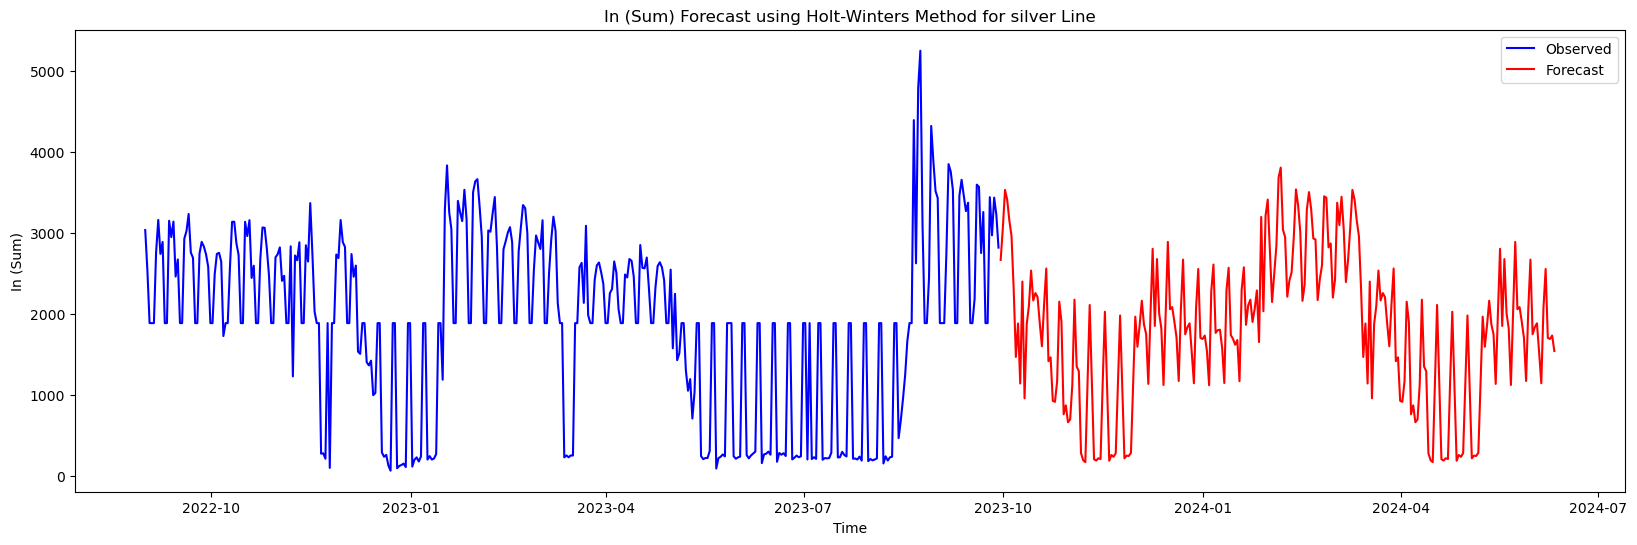

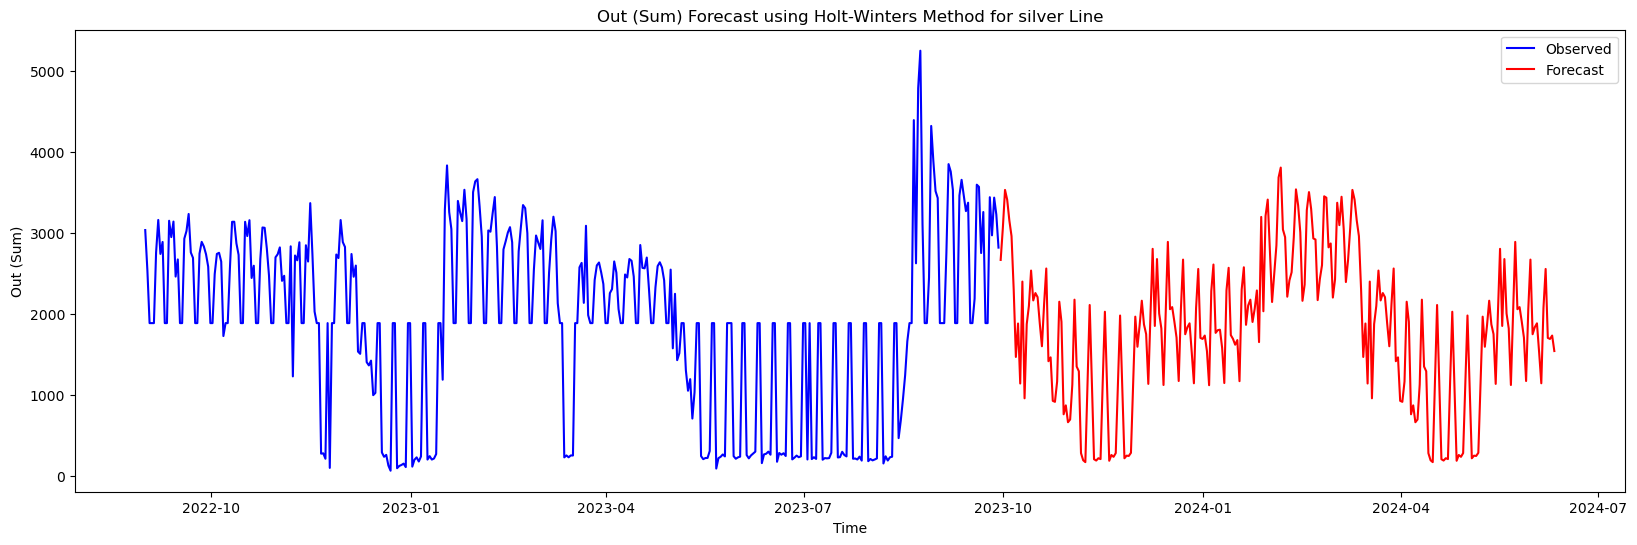

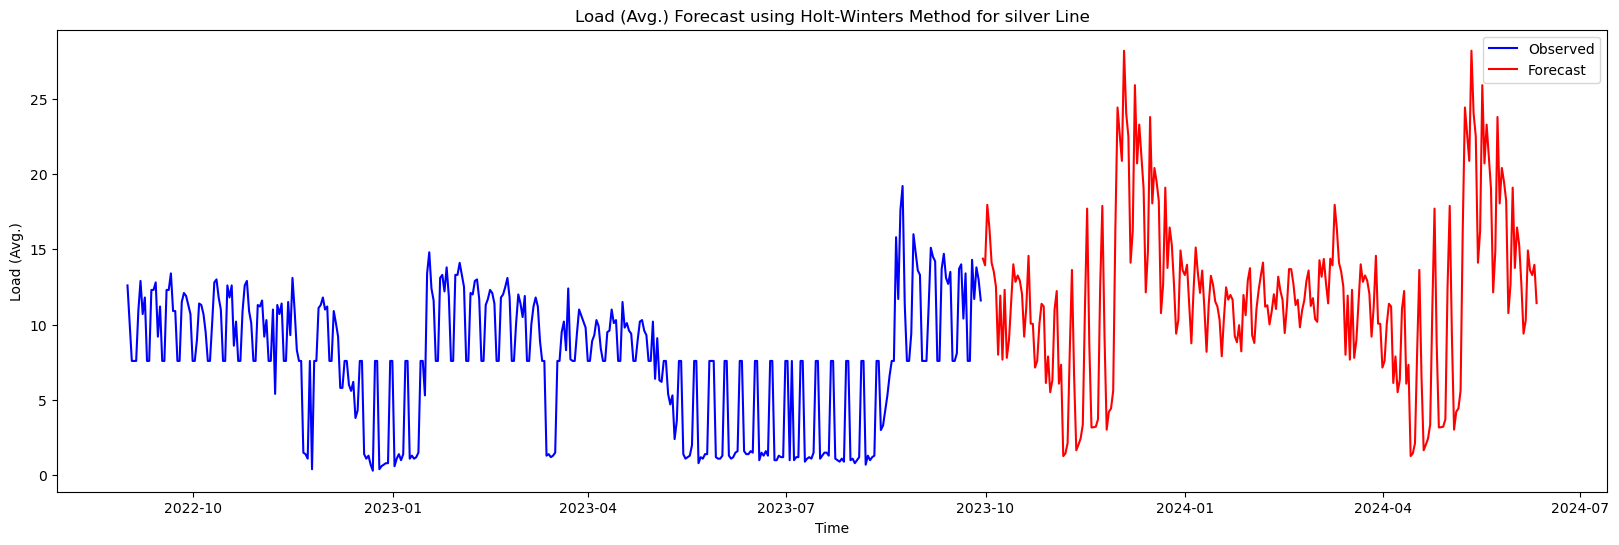

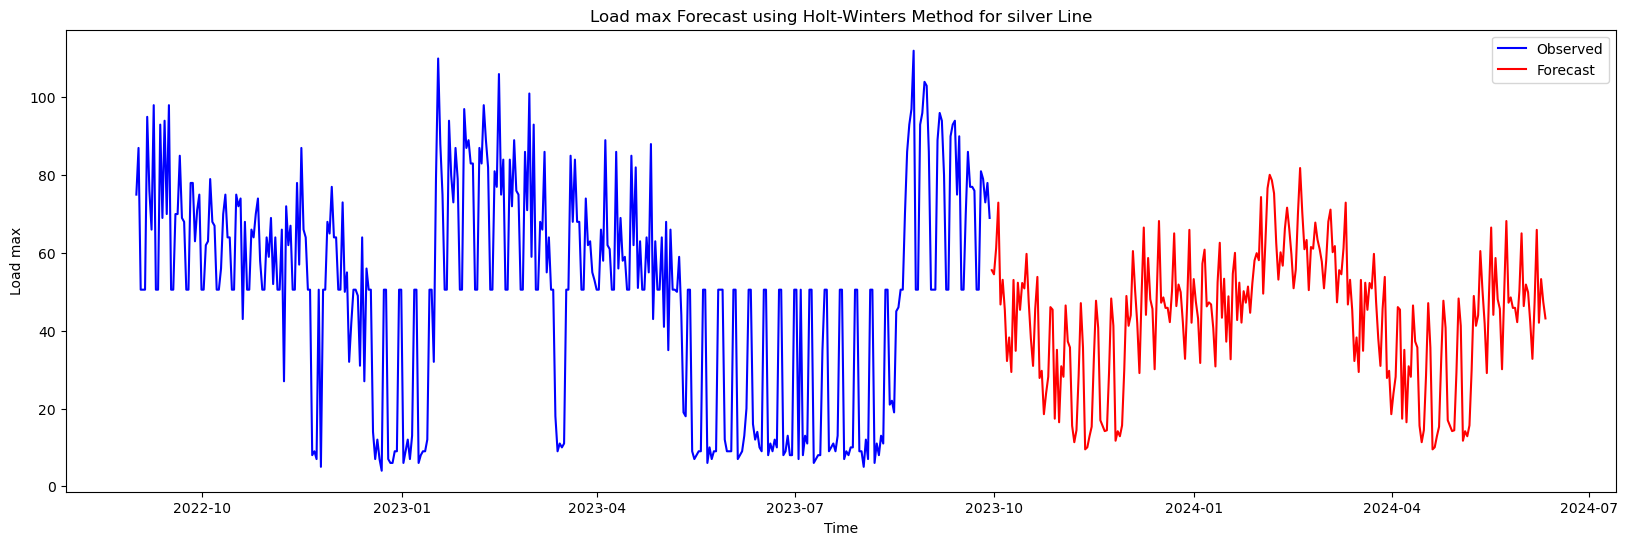

In [16]:
steps = [256,256,256,256]
for j,step in zip(columns_to_traverse,steps):
    forecast(silv,j,step)